In [1]:
import pandas as pd
import scipy as sc
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")
train = train.sample(frac=0.1, random_state=42)

In [3]:
def SMAPE(target, prediction):
    return 200*np.mean(np.abs(target-prediction)/(np.abs(target) + np.abs(prediction)))

In [4]:
def validate(estimator, train_data, log=False):
    X = train_data.drop(['Num','y'], axis=1)
    y = train_data['y']
    def do_stuff(train_indexes, check_indexes, line=''):
        estimator.fit(X[train_indexes], y[train_indexes])
        pred = estimator.predict(X[check_indexes])
        score = SMAPE(pred, y[check_indexes])
        if log:
            print line + str(score)
        return score
    scores = []
    scores.append(do_stuff(X['year'] < 2014, X['year'] == 2014, "trained on 2012, 2013, prediction for 2014: "))
    scores.append(do_stuff(X['year'] < 2014, X['year'] == 2015, "trained on 2012, 2013, prediction for 2015: "))
    scores.append(do_stuff(X['year'] < 2015, X['year'] == 2015, "trained on 2012 - 2014, prediction for 2015: "))
    scores.append(do_stuff(X['year'] == 2014, X['year'] == 2015, "trained on 2014, prediction for 2015: "))
    return scores

In [5]:
ohe = OneHotEncoder(sparse=False)
dummy_features = ohe.fit_transform(train['item_id'].values.reshape(-1, 1))
dummy_features = pd.DataFrame(dummy_features, columns=['good = ' + str(x) for x in range(dummy_features.shape[1])])
train.index = dummy_features.index
new_train = pd.concat([train, dummy_features], axis=1)

In [6]:
def test_alg(loss, n_estimators=50, log=False):
    print '\n'
    print 'loss: ' + loss 
    print 'estimators: ' + str(n_estimators)
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor(loss=loss, n_estimators=n_estimators, max_depth=5, random_state=43)
    if log:
        print 'raw: '
    raw_scores = validate(model, train, log)
    if log:
        print 'modified: '
    modified_scores = validate(model, new_train.drop(['item_id'], axis=1), log)
    return raw_scores, modified_scores

In [9]:
raw_scores = []
modified_scores = []
n_values = [1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150]
for n in n_values:
    r1, r2 = test_alg('lad', n, True)
    raw_scores.append(r1)
    modified_scores.append(r1)



loss: lad
estimators: 1
raw: 
trained on 2012, 2013, prediction for 2014: 109.741375951
trained on 2012, 2013, prediction for 2015: 116.145968216
trained on 2012 - 2014, prediction for 2015: 117.512006598
trained on 2014, prediction for 2015: 117.904698324
modified: 
trained on 2012, 2013, prediction for 2014: 110.781584201
trained on 2012, 2013, prediction for 2015: 116.506030753
trained on 2012 - 2014, prediction for 2015: 117.48250477
trained on 2014, prediction for 2015: 118.051735466


loss: lad
estimators: 5
raw: 
trained on 2012, 2013, prediction for 2014: 81.2275267969
trained on 2012, 2013, prediction for 2015: 105.501558904
trained on 2012 - 2014, prediction for 2015: 106.398917808
trained on 2014, prediction for 2015: 106.09141298
modified: 
trained on 2012, 2013, prediction for 2014: 81.9801437762
trained on 2012, 2013, prediction for 2015: 105.105975073
trained on 2012 - 2014, prediction for 2015: 106.491521499
trained on 2014, prediction for 2015: 106.116409768


loss: 

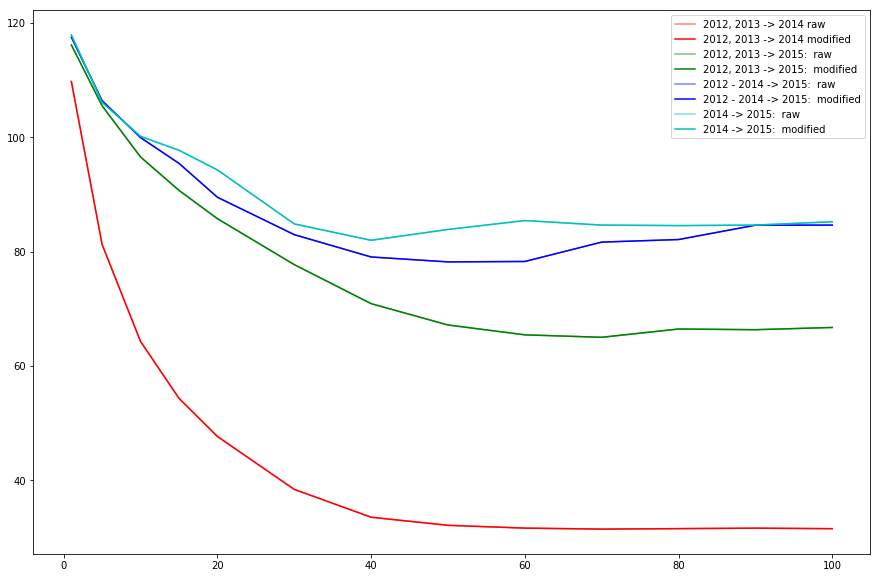

In [8]:
raw_scores_arr = np.array(raw_scores).transpose()
modified_scores_arr = np.array(modified_scores).transpose()
names = ["2012, 2013 -> 2014", "2012, 2013 -> 2015: ", 
        "2012 - 2014 -> 2015: ", "2014 -> 2015: "]
my_colors = ['r', 'g', 'b', 'c']

for i in range(4):    
    plt.plot(n_values, raw_scores_arr[i], label=names[i] + ' raw', color=my_colors[i], alpha = 0.5)
    plt.plot(n_values, modified_scores_arr[i], label=names[i] + ' modified', color=my_colors[i])
plt.legend()
plt.show()